In [1]:
import scanpy as sc
import matplotlib.pyplot as plt
import torch
import pickle
import pandas as pd
import numpy as np
import anndata as ad
import os, sys
import scipy.signal as signal
import scipy.stats as stats

import gseapy as gp

In [2]:
import sys
import importlib
sys.path.append('/home/masse/work/vae')
import networks
from config import dataset_cfg, model_cfg, task_cfg, trainer_cfg

importlib.reload(networks)

<module 'networks' from '/home/masse/work/vae/networks.py'>

In [3]:
meta_fn = "/home/masse/work/perceiver/mssm_rush_data_all_genes/test_metadata.pkl"
meta = pickle.load(open(meta_fn, "rb"))

In [4]:
def explained_var(x_pred, x_real):
    error = (x_pred - x_real) ** 2
    return 1 - np.nanmean(error) / np.nanvar(x_real)

In [5]:
def create_anndata(z, latent_dim, cell_decoder_latent_dim):
    
    latent = np.stack(z["latent"])
    latent = np.reshape(latent, (-1, latent_dim))
    gene_vals = np.reshape(z["gene_vals"], (-1, z["gene_vals"].shape[-1]))
    mask = np.reshape(z["cell_mask"], (-1, z["cell_mask"].shape[-1]))
    
    adata = ad.AnnData(gene_vals)
    adata.obsm['X_pca'] = latent[:, : cell_decoder_latent_dim]
    
    obs_list = ["AD", "Dementia", "CERAD", "BRAAK_AD", "Age"]
    batch_list = ["class", "subclass", "Sex", "Brain_bank", "ApoE_gt"]
    batch_prop_list = ["class", "subclass"]

    for obs in obs_list:
        adata.obs[obs]  = np.reshape(z[obs], (-1))
        print(obs, z[f"pred_{obs}"].shape)
        if z[f"pred_{obs}"].ndim == 3:
            s = np.argmax(z[f"pred_{obs}"], -1)
        else:
            s = z[f"pred_{obs}"]
        adata.obs[f"pred_{obs}"]  = np.reshape(s, (-1))
        
    
    for obs in batch_list:
        adata.obs[obs] = np.reshape(z[obs], (-1))
        
    """
    for obs in batch_prop_list:
        adata.obs[f"{obs}_index"] = np.reshape(z[obs], (-1))
    """

    for obs in batch_list:
        unique_list = np.unique(meta["obs"][obs])
        for n, u in enumerate(unique_list):
            idx = adata.obs[obs] == n
            adata.obs[obs][idx] = u
            
    for n, k in enumerate(["AD", "Dementia", "CERAD", "BRAAK_AD"]):
        idx = np.where(mask[:, n] == 0)[0]
        adata.obs[k][idx] = np.nan
            
    return adata

In [6]:
def subset_adata(adata, conditions):
    
    cond = 1
    for k, v in conditions.items():
        cond *= adata.obs[k] == v
    idx = np.where(cond)[0]
        
    return adata[idx]

In [7]:
def add_mean_scores(adata, n_neighbors = 30):
    
    sc.pp.neighbors(adata, n_neighbors=n_neighbors)
    sc.tl.umap(adata)
    
    """
    for obs in ["AD", "Dementia", "CERAD", "BRAAK_AD", "pred_AD", "pred_Dementia", "pred_CERAD", "pred_BRAAK_AD"]:
        x = []
        s = np.array(adata.obs[obs])
        for n in range(adata.shape[0]):
            c = np.array(adata.obsp["connectivities"][n, :].todense()).squeeze()
            count = np.sum(c > 0)
            x.append(np.sum(s * c) / count)
        adata.obs[f"mean_{obs}"] = x
    """
        
    return adata

In [8]:
def simulate_trajectory(adata, initial_condition, obs_gradient="mean_CERAD", steps=1000):
    
    
    cond = 1
    for k, v in initial_condition.items():
        cond *= adata.obs[k] == v
    idx = np.where(cond)[0]
    print(len(idx))
    

    i = np.random.choice(idx)
    x = [adata.obsm["X_umap"][i, :]]
    print(x)

    scores = []
    time = [0]
    
    for t in range(steps):
        idx = np.where(np.array(adata.obsp["connectivities"][i, :].todense()).squeeze())[0]
        current_score = adata.obs[obs_gradient].values[i]
        scores.append(current_score)
        neighbor_scores = adata.obs[obs_gradient].values[idx]
        
        idx_sort = np.argsort(neighbor_scores)
        idx = idx[idx_sort]
        neighbor_scores = neighbor_scores[idx_sort]
        
        next_idx = np.where(neighbor_scores > current_score)[0]
        if len(next_idx) == 0:
            break
          
        i = idx[next_idx[0]]
        
        x.append([adata.obsm["X_umap"][i, :]])
        time.append(t / steps)
        
    return x, scores, time
        


In [9]:
v_num = 15
fn = f"/home/masse/work/vae/lightning_logs/version_{v_num}/test_results.pkl"
z = pickle.load(open(fn, "rb"))
adata = create_anndata(z, 32, 32)
del z

AD (30, 1024)
Dementia (30, 1024)
CERAD (30, 1024)
BRAAK_AD (30, 1024)
Age (30, 1024)


/tmp/ipykernel_94672/1619907465.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs[obs][idx] = u
/tmp/ipykernel_94672/1619907465.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs[obs][idx] = u
/tmp/ipykernel_94672/1619907465.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs[obs][idx] = u
/tmp/ipykernel_94672/1619907465.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

/tmp/ipykernel_94672/1619907465.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs[obs][idx] = u
/tmp/ipykernel_94672/1619907465.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs[obs][idx] = u
/tmp/ipykernel_94672/1619907465.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs[obs][idx] = u
/tmp/ipykernel_94672/1619907465.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

In [9]:
path = f"/home/masse/work/vae/lightning_logs/version_{v_num}/checkpoints/"
fns = os.listdir(path)
fn = path + fns[0]

class_unique = ['Astro', 'EN', 'Endo', 'IN', 'Immune', 'Mural', 'OPC', 'Oligo']
subclass_unique = list(np.unique(meta["obs"]["subclass"]))

model_cfg["n_input"] = adata.shape[1]
model_cfg["batch_properties"] = {"class": {"values": class_unique}, "subclass": {"values": subclass_unique}}
model_cfg["batch_properties"] = None
network = networks.VAE(**model_cfg)
network = networks.load_model(fn, network)

n_input 13585 n_hidden 64
NNN 2
encoder drop: 0.5
NNN 1
encoder drop: 0.5
NNN 2
Number of params loaded: 25
Non-network parameters not loaded: []


In [10]:
print("Explained variance")
for k in ["AD", "Dementia", "CERAD", "BRAAK_AD"]:
    s0 = adata.obs[k].values
    s1 = adata.obs[f"pred_{k}"].values
    ex = explained_var(s1, s0)
    print(f"{k}: {ex:1.4f}")

Explained variance
AD: 0.1343
Dementia: 0.1378
CERAD: 0.2673
BRAAK_AD: 0.2510


TypeError: 'Axes' object is not subscriptable

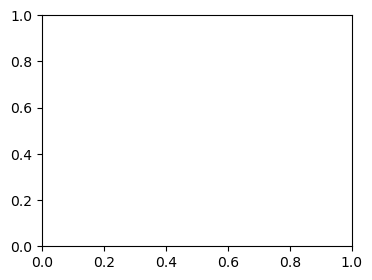

In [13]:


f, ax = plt.subplots(1, 1, figsize=(4,3))

for n, sub in enumerate(adata.obs["class"].unique()):
    if n >= 9:
        continue
    a = subset_adata(adata, {"subclass": sub})
    s0 = a.obs["CERAD"].values
    s1 = a.obs["BRAAK_AD"].values
    p0 = a.obs["pred_CERAD"].values
    p1 = a.obs["pred_BRAAK_AD"].values
    ex0 = explained_var(p0, s0)
    ex1 = explained_var(p1, s1)
    axis = ax[n // 1, n % 1]
    axis.plot(np.sort(p0), label="pred CERAD")
    axis.plot(np.sort(p1), label="pred BRAAK")
    axis.legend()
    axis.set_title(f"{sub} cerad: {ex0:1.3f} braak: {ex1:1.3f}", fontsize=10)

plt.tight_layout()
plt.show()


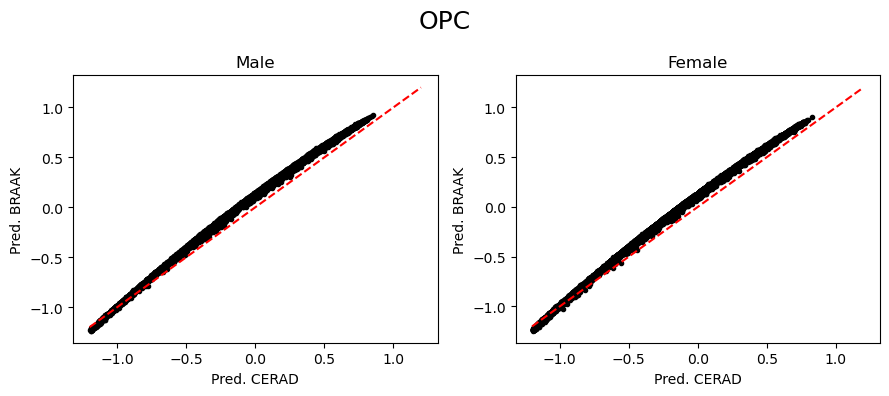

In [11]:
f, ax = plt.subplots(1,2, figsize=(9,4))

for n, s in enumerate(["Male", "Female"]):
    idx_sex = adata.obs["Sex"] == s 
    x0 = adata.obs["pred_CERAD"].values[idx_sex]
    x1 = adata.obs["pred_BRAAK_AD"].values[idx_sex]
    ax[n].plot(x0, x1, 'k.')
    ax[n].set_xlabel("Pred. CERAD")
    ax[n].set_ylabel("Pred. BRAAK")
    ax[n].set_title(s)
    ax[n].plot([-1.2, 1.2], [-1.2, 1.2], 'r--')
    
plt.suptitle("OPC", fontsize=18)
plt.tight_layout()
plt.show()

In [12]:
unique_cerad = np.unique(adata.obs["CERAD"])
unique_cerad = unique_cerad[~np.isnan(unique_cerad)]
unique_braak = np.unique(adata.obs["BRAAK_AD"])
unique_braak = unique_braak[~np.isnan(unique_braak)]
[np.mean(unique_cerad), np.mean(unique_braak), unique_braak]

[2.9802322e-08,
 0.0,
 array([-1.5, -1. , -0.5,  0. ,  0.5,  1. ,  1.5], dtype=float32)]

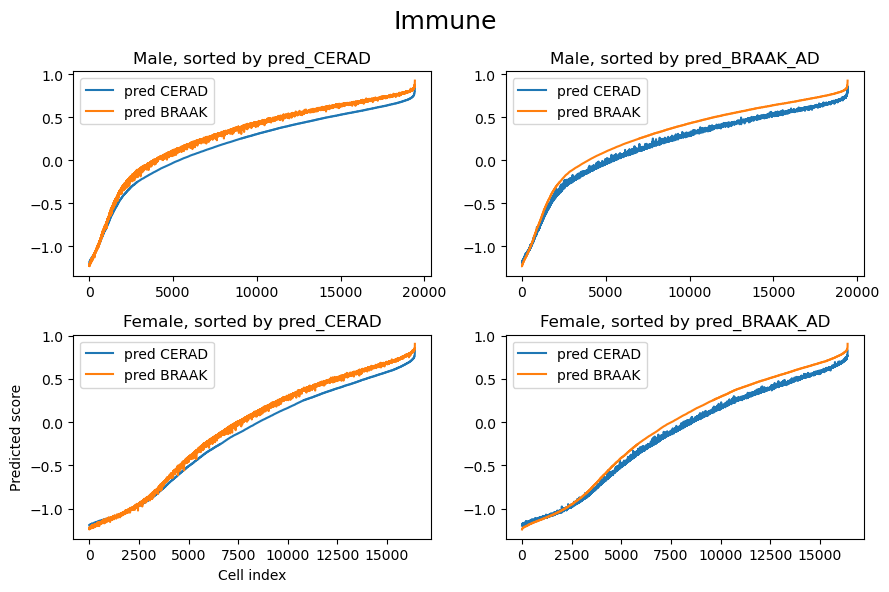

In [13]:
f, ax = plt.subplots(2,2, figsize=(9,6))

for n, s in enumerate(["Male", "Female"]):
    idx_sex = adata.obs["Sex"] == s 
    x0 = adata.obs["pred_CERAD"].values[idx_sex]
    x1 = adata.obs["pred_BRAAK_AD"].values[idx_sex]
    idx = np.argsort(x0)
    ax[n,0].plot(x0[idx], label="pred CERAD")
    ax[n,0].plot(x1[idx], label="pred BRAAK", alpha=1.0)
    ax[n,0].legend()
    ax[n,0].set_title(f"{s}, sorted by pred_CERAD")

    idx = np.argsort(x1)
    ax[n,1].plot(x0[idx], label="pred CERAD", alpha=1.0)
    ax[n,1].plot(x1[idx], label="pred BRAAK")
    ax[n,1].legend()
    ax[n,1].set_title(f"{s}, sorted by pred_BRAAK_AD")
    
    if n == 1:
        ax[n,0].set_xlabel("Cell index")
        ax[n,0].set_ylabel("Predicted score")

plt.suptitle("Immune", fontsize=18)
plt.tight_layout()
plt.show()

In [10]:
x0 = adata.obs["pred_CERAD"].values
x1 = adata.obs["pred_BRAAK_AD"].values
idx_cell = np.argsort(x0)

In [11]:
x = adata.X[idx_cell, :].astype(np.float32)

In [12]:
N = 5_000
d0 = np.mean(x[:N, :], axis=0)
d1 = np.mean(x[N: 2*N, :], axis=0)
m = np.mean(x, axis=0)
idx_gene = np.argsort((d1 - d0) / (m + 0.01))

In [13]:
gene_names = meta["var"]["gene_name"]
gene_names = gene_names[meta["var"]["protein_coding"]]
nf = 250
f = np.ones(nf) / nf
xa = signal.convolve(x0[idx_cell], f)

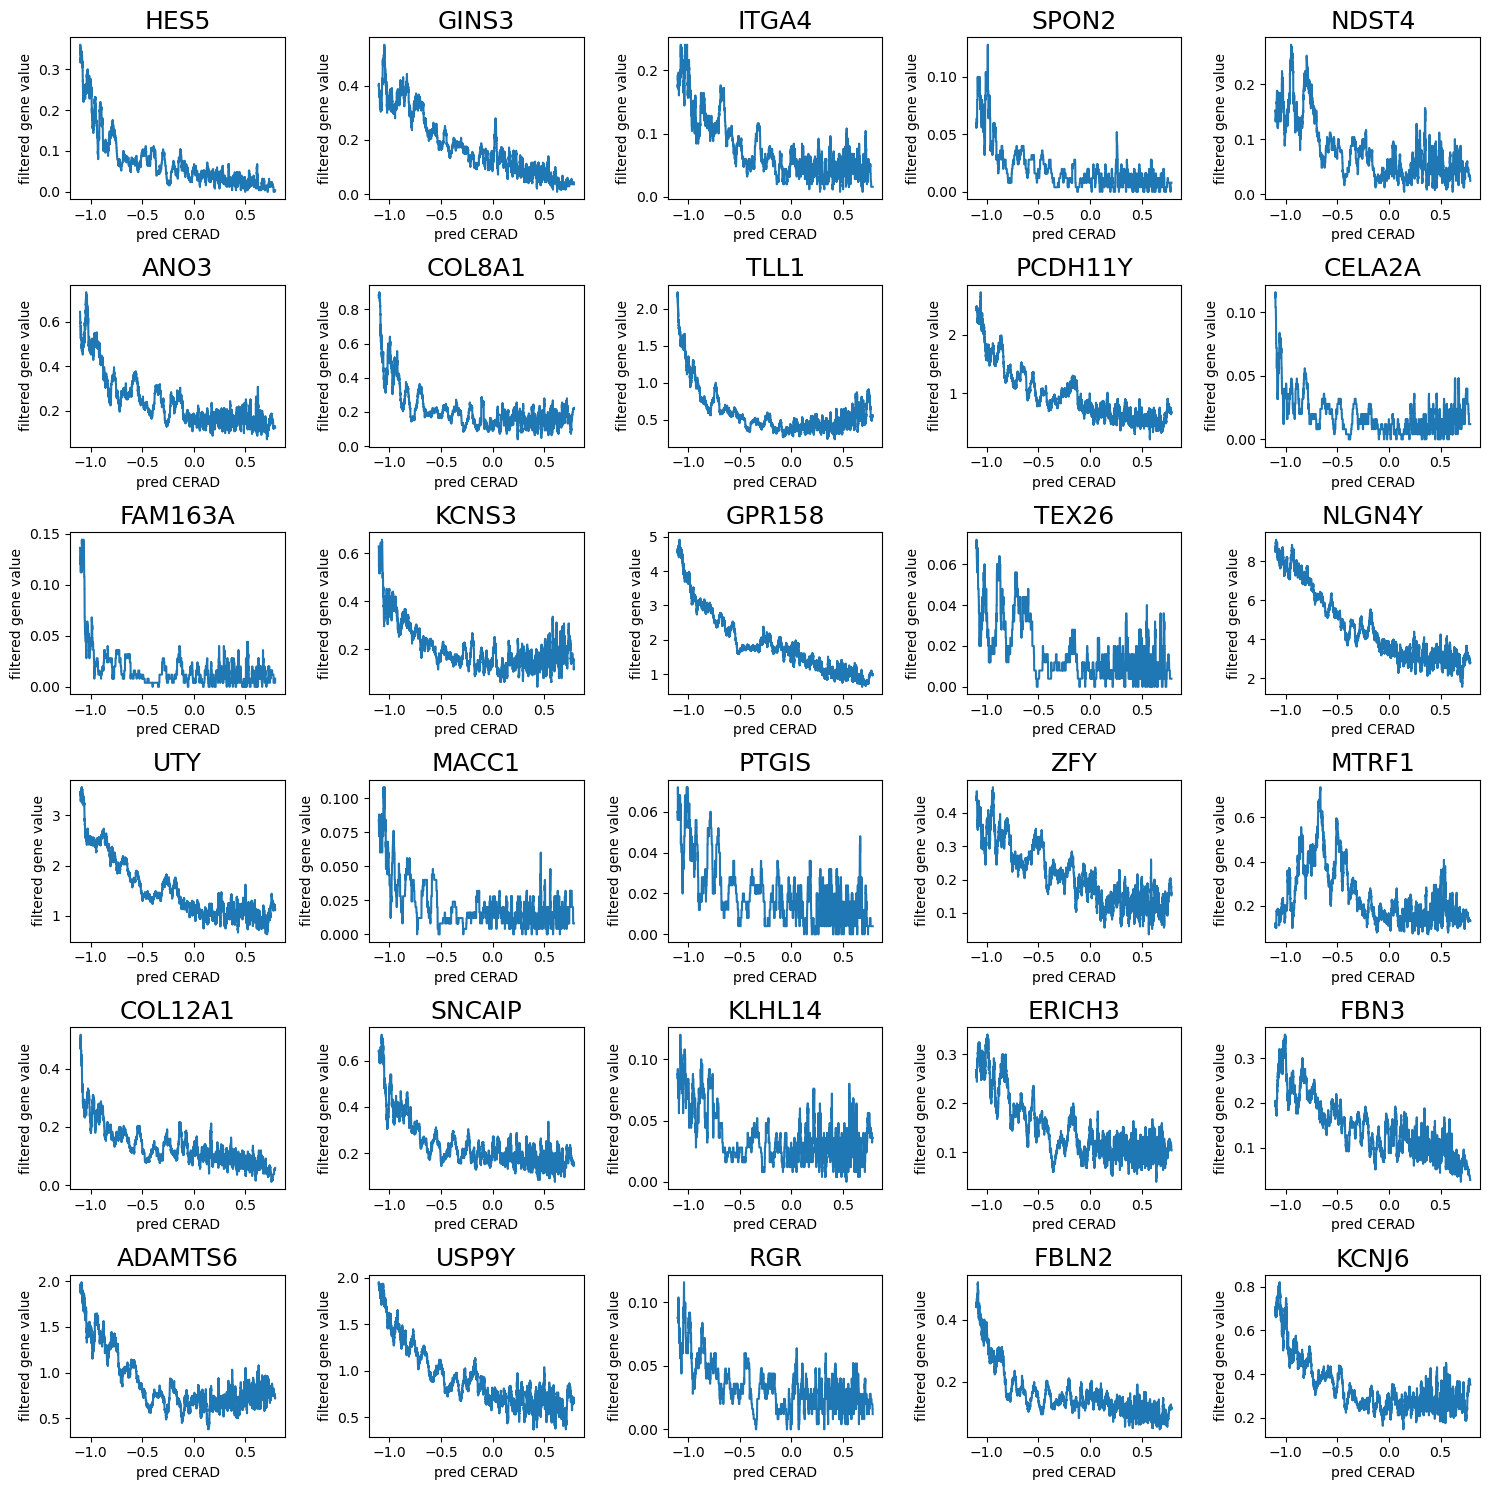

In [14]:
fig, ax = plt.subplots(6,5,figsize=(15,15))
nf = 250
f = np.ones(nf) / nf
for n, i in enumerate(idx_gene[:30]):
    axis = ax[n // 5, n % 5]
    y1 = signal.convolve(x[:, i], f)
    axis.plot(xa[nf:-nf], y1[nf:-nf])
    axis.set_title(f"{gene_names[i]}", fontsize=18)
    axis.set_xlabel("pred CERAD")
    axis.set_ylabel("filtered gene value")
    
plt.tight_layout()
plt.show()

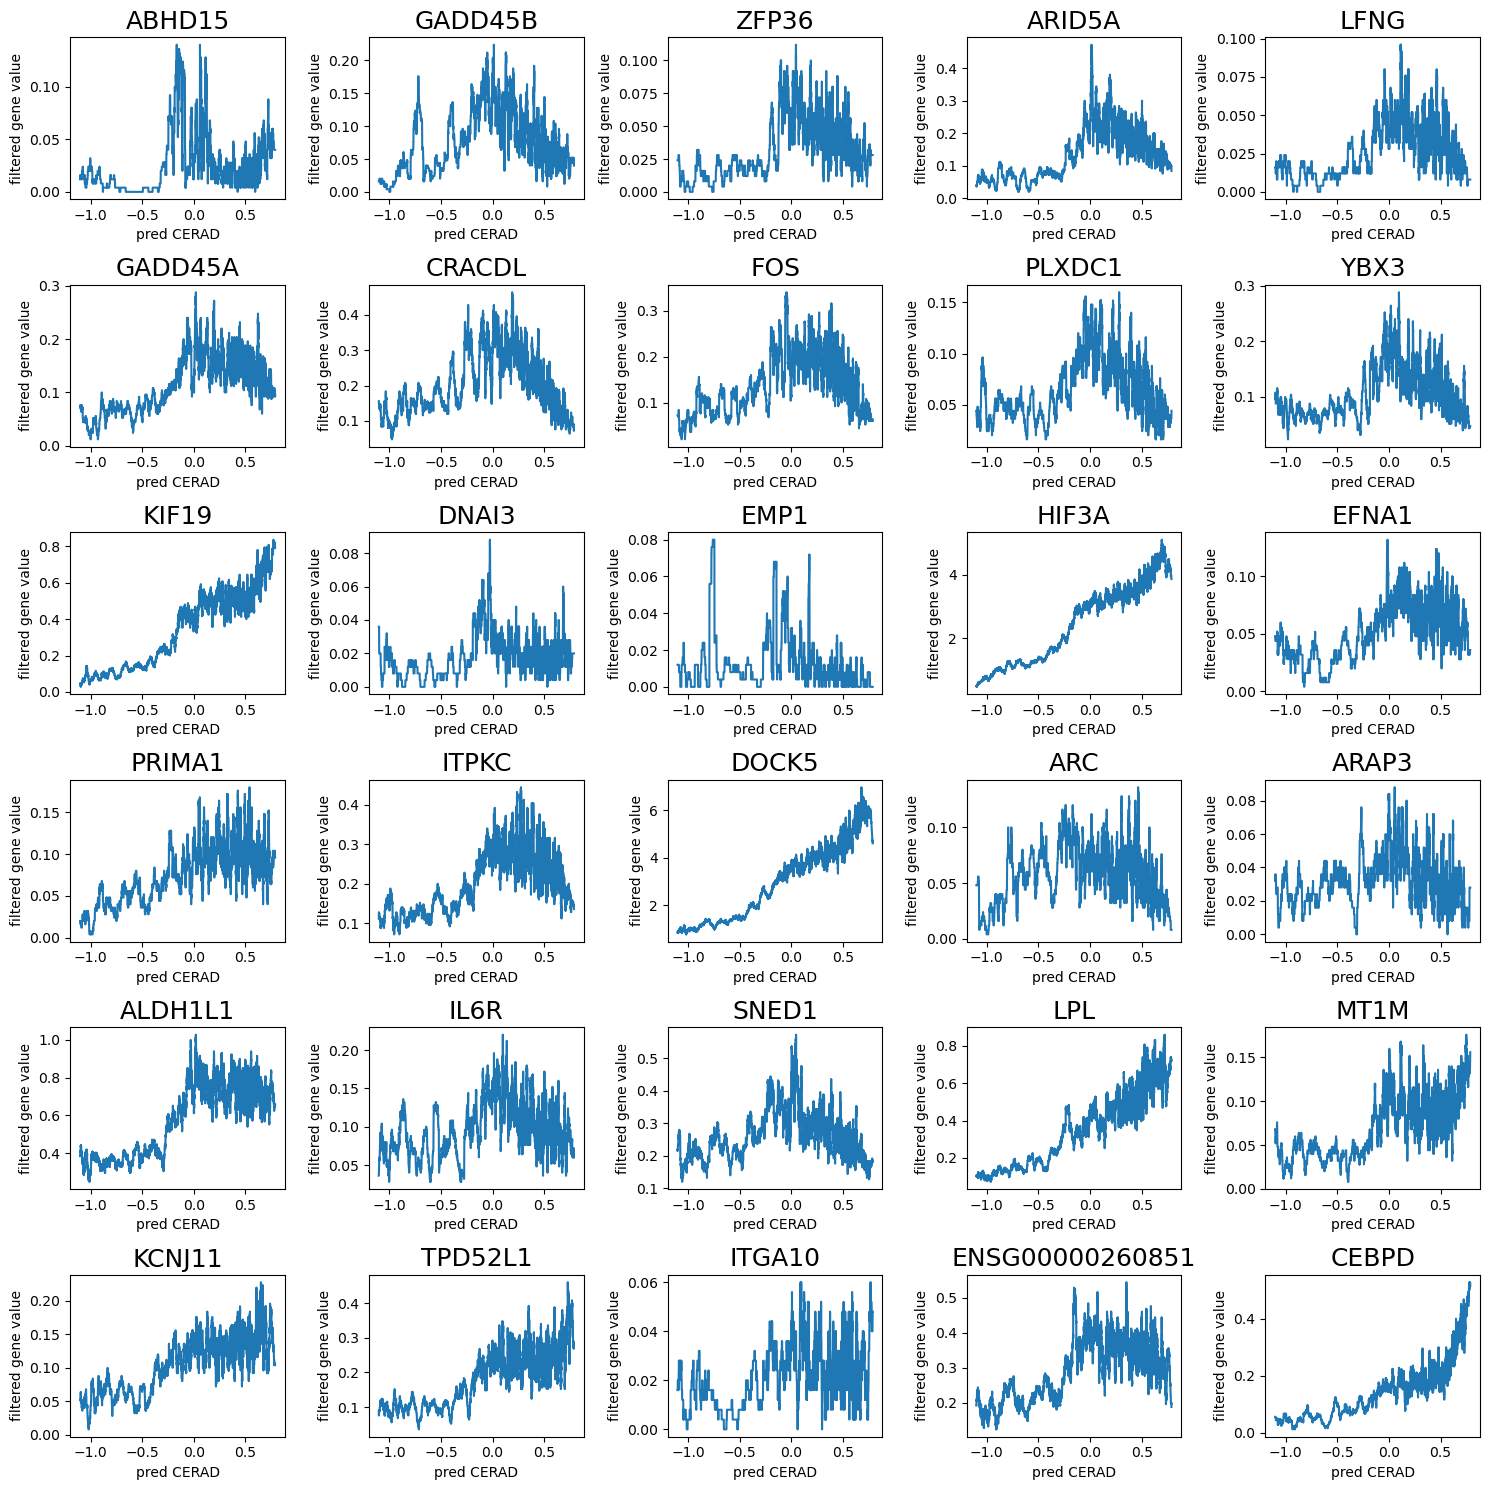

In [15]:
fig, ax = plt.subplots(6,5,figsize=(15,15))

for n, i in enumerate(idx_gene[-30:][::-1]):
    axis = ax[n // 5, n % 5]
    y1 = signal.convolve(x[:, i], f)
    
    axis.plot(xa[nf:-nf], y1[nf:-nf])
    axis.set_title(f"{gene_names[i]}", fontsize=18)
    axis.set_xlabel("pred CERAD")
    axis.set_ylabel("filtered gene value")
    
plt.tight_layout()
plt.show()

In [16]:
genes_downregulated = [gene_names[i] for i in idx_gene[:200]]
gene_sets = [
    'MSigDB_Hallmark_2020',
    'KEGG_2021_Human',
    #'Human_Gene_Atlas',
    'MGI_Mammalian_Phenotype_Level_4_2021',
]


enr = gp.enrichr(
    gene_list=genes_downregulated, # or "./tests/data/gene_list.txt",
    gene_sets=gene_sets,
    organism='human', # don't forget to set organism to the one you desired! e.g. Yeast
    outdir=None, # don't write to disk
)

enr.results.head(20)

Gene_set                               Term Overlap   P-value  \
0   MSigDB_Hallmark_2020  Epithelial Mesenchymal Transition  11/200  0.000006   
1   MSigDB_Hallmark_2020                    Notch Signaling    2/32  0.040555   
2   MSigDB_Hallmark_2020      TNF-alpha Signaling via NF-kB   5/200  0.050844   
3   MSigDB_Hallmark_2020                    Apical Junction   5/200  0.050844   
4   MSigDB_Hallmark_2020                     UV Response Dn   4/144  0.056750   
5   MSigDB_Hallmark_2020                  KRAS Signaling Dn   4/200  0.141046   
6   MSigDB_Hallmark_2020           PI3K/AKT/mTOR  Signaling   2/105  0.282755   
7   MSigDB_Hallmark_2020                 Hedgehog Signaling    1/36  0.303808   
8   MSigDB_Hallmark_2020                       Angiogenesis    1/36  0.303808   
9   MSigDB_Hallmark_2020                    G2-M Checkpoint   3/200  0.323304   
10  MSigDB_Hallmark_2020             Estrogen Response Late   3/200  0.323304   
11  MSigDB_Hallmark_2020          Interferon Gamma Response   3/200  0.323304   
12  MSigDB_Hallmark_2020                  KRAS Signaling Up   3/200  0.323304   
13  MSigDB_Hallmark_2020         Wnt-beta Catenin Signaling    1/42  0.344626   
14  MSigDB_Hallmark_2020                     Apical Surface    1/44  0.357695   
15  MSigDB_Hallmark_2020                 TGF-beta Signaling    1/54  0.419254   
16  MSigDB_Hallmark_2020           IL-6/JAK/STAT3 Signaling    1/87  0.583668   
17  MSigDB_Hallmark_2020               IL-2/STAT5 Signaling   2/199  0.593973   
18  MSigDB_Hallmark_2020                            Hypoxia   2/200  0.596707   
19  MSigDB_Hallmark_2020            Estrogen Response Early   2/200  0.596707   

    Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
0           0.000205            0                     0    6.039053   
1           0.408598            0                     0    6.656566   
2           0.408598            0                     0    2.577909   
3           0.408598            0                     0    2.577909   
4           0.408598            0                     0    2.865889   
5           0.846275            0                     0    2.041233   
6           0.846512            0                     0    1.931647   
7           0.846512            0                     0    2.837760   
8           0.846512            0                     0    2.837760   
9           0.846512            0                     0    1.515344   
10          0.846512            0                     0    1.515344   
11          0.846512            0                     0    1.515344   
12          0.846512            0                     0    1.515344   
13          0.846512            0                     0    2.421743   
14          0.846512            0                     0    2.308870   
15          0.846512            0                     0    1.872286   
16          0.846512            0                     0    1.151922   
17          0.846512            0                     0    1.005127   
18          0.846512            0                     0    1.000000   
19          0.846512            0                     0    1.000000   

    Combined Score                                              Genes  
0        72.933498  CDH6;NT5E;ITGB5;COL12A1;WNT5A;SLIT2;THBS2;FBLN...  
1        21.334852                                        CCND1;WNT5A  
2         7.679574                    SMAD3;CCND1;TNFAIP6;GFPT2;VEGFA  
3         7.679574                   CDH6;PIK3R3;SLIT2;ADRA1B;NECTIN1  
4         8.222533                          SMAD3;PRKAR2B;PIK3R3;CAP2  
5         3.998102                              NR6A1;NGB;CLDN16;BRDT  
6         2.440009                                      PIK3R3;MAP2K6  
7         3.380791                                              VEGFA  
8         3.380791                                              VEGFA  
9         1.711067                                   TPX2;SMAD3;CCND1  
10        1.711067            

In [17]:
genes_upregulated = [gene_names[i] for i in idx_gene[-200:]]
gene_sets = [
    'MSigDB_Hallmark_2020',
    'KEGG_2021_Human',
    #'Human_Gene_Atlas',
    'MGI_Mammalian_Phenotype_Level_4_2021',
]


enr = gp.enrichr(
    gene_list=genes_upregulated, # or "./tests/data/gene_list.txt",
    gene_sets=gene_sets,
    organism='human', # don't forget to set organism to the one you desired! e.g. Yeast
    outdir=None, # don't write to disk
)

enr.results.head(20)

Gene_set                           Term Overlap       P-value  \
0   MSigDB_Hallmark_2020  TNF-alpha Signaling via NF-kB  20/200  1.287534e-14   
1   MSigDB_Hallmark_2020                    p53 Pathway  16/200  1.848166e-10   
2   MSigDB_Hallmark_2020                        Hypoxia  14/200  1.467128e-08   
3   MSigDB_Hallmark_2020                 UV Response Up   9/158  3.104726e-05   
4   MSigDB_Hallmark_2020      Interferon Gamma Response  10/200  3.460095e-05   
5   MSigDB_Hallmark_2020           IL-2/STAT5 Signaling   9/199  1.830229e-04   
6   MSigDB_Hallmark_2020                      Apoptosis   8/161  2.212159e-04   
7   MSigDB_Hallmark_2020               mTORC1 Signaling   8/200  9.340556e-04   
8   MSigDB_Hallmark_2020          Inflammatory Response   8/200  9.340556e-04   
9   MSigDB_Hallmark_2020       IL-6/JAK/STAT3 Signaling    5/87  1.810249e-03   
10  MSigDB_Hallmark_2020                   Adipogenesis   7/200  4.067400e-03   
11  MSigDB_Hallmark_2020         Estrogen Response Late   7/200  4.067400e-03   
12  MSigDB_Hallmark_2020          Xenobiotic Metabolism   7/200  4.067400e-03   
13  MSigDB_Hallmark_2020                     Glycolysis   7/200  4.067400e-03   
14  MSigDB_Hallmark_2020       PI3K/AKT/mTOR  Signaling   5/105  4.096032e-03   
15  MSigDB_Hallmark_2020                     Myogenesis   6/200  1.549399e-02   
16  MSigDB_Hallmark_2020      Interferon Alpha Response    4/97  1.633987e-02   
17  MSigDB_Hallmark_2020             TGF-beta Signaling    3/54  1.681610e-02   
18  MSigDB_Hallmark_2020      Unfolded Protein Response   4/113  2.688002e-02   
19  MSigDB_Hallmark_2020                Notch Signaling    2/32  4.055549e-02   

    Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
0       5.793901e-13            0                     0   12.111111   
1       4.158374e-09            0                     0    9.270321   
2       2.200693e-07            0                     0    7.937218   
3       3.114085e-04            0                     0    6.214519   
4       3.114085e-04            0                     0    5.432133   
5       1.372672e-03            0                     0    4.863323   
6       1.422102e-03            0                     0    5.350490   
7       4.670278e-03            0                     0    4.255208   
8       4.670278e-03            0                     0    4.255208   
9       8.146123e-03            0                     0    6.165729   
10      1.228810e-02            0                     0    3.684636   
11      1.228810e-02            0                     0    3.684636   
12      1.228810e-02            0                     0    3.684636   
13      1.228810e-02            0                     0    3.684636   
14      1.228810e-02            0                     0    5.051282   
15      4.204026e-02            0                     0    3.125624   
16      4.204026e-02            0                     0    4.324556   
17      4.204026e-02            0                     0    5.896984   
18      6.366320e-02            0                     0    3.686763   
19      9.124986e-02            0                     0    6.656566   

    Combined Score                                              Genes  
0       387.355272  STAT5A;EGR1;BTG2;CDKN1A;GADD45B;CSF1;CEBPD;GAD...  
1       207.763263  TSPYL2;CDKN1A;BTG2;GADD45A;CD81;ITGB4;DCXR;VWA...  
2       143.166570  CDKN1C;SRPX;CDKN1A;DUSP1;SERPINE1;ENO1;FOS;HK2...  
3        64.506709  NFKBIA;CDKN1C;BTG2;TYRO3;TAP1;FOS;HLA-F;NPTX2;...  
4        55.796857  ISG20;NFKBIA;CDKN1A;MTHFD2;STAT3;PIM1;SERPING1...  
5        41.853269  CDKN1C;CDCP1;GADD45B;CSF1;CD81;PIM1;EMP1;HK2;S...  
6        45.031713    ISG20;CDKN1A;BTG2;GADD45B;GADD45A;CTH;TAP1;EMP1  
7        29.684225          CDKN1A;BTG2;MTHFD2;CTH;DDIT4;SLA;ENO1;HK2  
8        29.684225   NFKBIA;CDKN1A;BTG2;FZD5;CSF1;IRAK2;SERPINE1;OSMR  
9        38.932202                      CSF1;STAT3;PIM1;OSMR;TNFRSF1A  
10       20.283004            

In [18]:
genes_upregulated = [gene_names[i] for i in idx_gene[-200:]]
genes_downregulated = [gene_names[i] for i in idx_gene[:200]]

gene_sets = [
    'MSigDB_Hallmark_2020',
    'KEGG_2021_Human',
    #'Human_Gene_Atlas',
    'MGI_Mammalian_Phenotype_Level_4_2021',
]


enr = gp.enrichr(
    gene_list=genes_downregulated + genes_upregulated, # or "./tests/data/gene_list.txt",
    gene_sets=gene_sets,
    organism='human', # don't forget to set organism to the one you desired! e.g. Yeast
    outdir=None, # don't write to disk
)

enr.results.head(20)

Gene_set                               Term Overlap  \
0   MSigDB_Hallmark_2020      TNF-alpha Signaling via NF-kB  25/200   
1   MSigDB_Hallmark_2020                        p53 Pathway  18/200   
2   MSigDB_Hallmark_2020                            Hypoxia  16/200   
3   MSigDB_Hallmark_2020  Epithelial Mesenchymal Transition  16/200   
4   MSigDB_Hallmark_2020          Interferon Gamma Response  13/200   
5   MSigDB_Hallmark_2020                     UV Response Up  10/158   
6   MSigDB_Hallmark_2020               IL-2/STAT5 Signaling  11/199   
7   MSigDB_Hallmark_2020                    Notch Signaling    4/32   
8   MSigDB_Hallmark_2020           PI3K/AKT/mTOR  Signaling   7/105   
9   MSigDB_Hallmark_2020                          Apoptosis   9/161   
10  MSigDB_Hallmark_2020             Estrogen Response Late  10/200   
11  MSigDB_Hallmark_2020              Inflammatory Response  10/200   
12  MSigDB_Hallmark_2020           IL-6/JAK/STAT3 Signaling    6/87   
13  MSigDB_Hallmark_2020                     UV Response Dn   8/144   
14  MSigDB_Hallmark_2020                   mTORC1 Signaling   9/200   
15  MSigDB_Hallmark_2020                         Glycolysis   9/200   
16  MSigDB_Hallmark_2020                 TGF-beta Signaling    4/54   
17  MSigDB_Hallmark_2020                       Angiogenesis    3/36   
18  MSigDB_Hallmark_2020                       Adipogenesis   8/200   
19  MSigDB_Hallmark_2020                         Myogenesis   8/200   

         P-value  Adjusted P-value  Old P-value  Old Adjusted P-value  \
0   2.938215e-13      1.380961e-11            0                     0   
1   1.201504e-07      2.823533e-06            0                     0   
2   2.886454e-06      3.391583e-05            0                     0   
3   2.886454e-06      3.391583e-05            0                     0   
4   2.045469e-04      1.922741e-03            0                     0   
5   1.327979e-03      1.040250e-02            0                     0   
6   2.296855e-03      1.542174e-02            0                     0   
7   3.639561e-03      2.138242e-02            0                     0   
8   5.164935e-03      2.443194e-02            0                     0   
9   5.198285e-03      2.443194e-02            0                     0   
10  7.170791e-03      2.808560e-02            0                     0   
11  7.170791e-03      2.808560e-02            0                     0   
12  7.990562e-03      2.857711e-02            0                     0   
13  8.512329e-03      2.857711e-02            0                     0   
14  1.960121e-02      5.757856e-02            0                     0   
15  1.960121e-02      5.757856e-02            0                     0   
16  2.273480e-02      6.285504e-02            0                     0   
17  3.483914e-02      9.096888e-02            0                     0   
18  4.845120e-02      1.035094e-01            0                     0   
19  4.845120e-02      1.035094e-01            0                     0   

    Odds Ratio  Combined Score  \
0     7.400000      213.532949   
1     5.027386       80.108996   
2     4.396739       56.082526   
3     4.396739       56.082526   
4     3.487253       29.623212   
5     3.370062       22.323620   
6     2.919816       17.741429   
7     7.060606       39.651602   
8     3.544529       18.665004   
9     2.945080       15.489432   
10    2.619433       12.934078   
11    2.619433       12.934078   
12    3.669675       17.722673   
13    2.920768       13.921082   
14    2.339029        9.197444   
15    2.339029        9.197444   
16    3.949495       14.944330   
17    4.480650       15.041605   
18    2.062925        6.244883   
19    2.062925        6.244883   

                                                Genes  
0   BTG2;CDKN1A;CSF1;TNFAIP6;CEBPD;SERPINE1;ZFP36;...  
1   TSPYL2;CDKN1A;BTG2;CD82;GADD45A;CD81;ITGB4;DCX...  
2   CDKN1C;SRPX;CDKN1A;DUSP1;NCAN;SERPINE1;ENO1;FO...  
3   OXTR;NNMT;GADD45B;ITGB5;GADD45A;SERPINE1;COL12.

In [63]:
fn = "/home/masse/work/mssm/psuedotime/data/230512_FreshMG_PsychAD_meta.res.combined.csv"
df = pd.read_csv(fn)
df = df[df.coef == "CERAD"]
df = df[df.assay == "MG_Homeo_PICALM"]

In [61]:
df

ID            assay  estimate  std.error  statistic   p.value  \
97917   A1BG    MG_Adapt_AIF1  0.139092   0.073045   1.904211  0.056883   
97918   A1BG    MG_Adapt_HIST -0.045269   0.073972  -0.611980  0.540551   
97919   A1BG  MG_Adapt_HSPA1A  0.120131   0.083555   1.437750  0.150505   
97920   A1BG  MG_Homeo_PICALM  0.060495   0.062066   0.974702  0.329708   
97921   A1BG     MG_PVM_CD163 -0.040016   0.067609  -0.591881  0.553931   
...      ...              ...       ...        ...        ...       ...   
195829  ZZZ3  MG_Homeo_FRMD4A -0.018837   0.013499  -1.395437  0.162884   
195830  ZZZ3  MG_Homeo_PICALM  0.014798   0.010690   1.384209  0.166295   
195831  ZZZ3     MG_PVM_CD163  0.031868   0.011820   2.696114  0.007015   
195832  ZZZ3     MG_PVM_GPNMB  0.082358   0.022167   3.715305  0.000203   
195833  ZZZ3  MG_Prolif_MKI67 -0.028074   0.025617  -1.095883  0.273130   

         coef       FDR  log10FDR  
97917   CERAD  0.622478  0.205876  
97918   CERAD  0.930452  0.031306  
97919   CERAD  0.955298  0.019861  
97920   CERAD  0.697821  0.156256  
97921   CERAD  0.892930  0.049182  
...       ...       ...       ...  
195829  CERAD  0.443364  0.353240  
195830  CERAD  0.518630  0.285142  
195831  CERAD  0.148332  0.828766  
195832  CERAD  0.018513  1.732518  
195833  CERAD  0.770518  0.113217  

[97917 rows x 9 columns]

In [66]:
"ZZZ3" in df.ID.values
df0 = df[df.ID=="ZZZ3"]
df0

ID            assay  estimate  std.error  statistic   p.value  \
195830  ZZZ3  MG_Homeo_PICALM  0.014798    0.01069   1.384209  0.166295   

         coef      FDR  log10FDR  
195830  CERAD  0.51863  0.285142

In [69]:
diff = (d1 - d0) / (m + 1e-1)
s0 = []
s1 = []
for n, g in enumerate(gene_names):
    if not g in df.ID.values:
        continue
    else:
        df0 = df[df.ID==g]
    s0.append(diff[n])
    s1.append(df0.statistic.values[0])
        

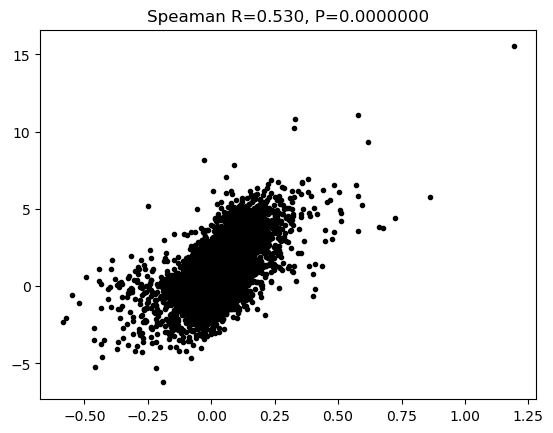

In [77]:
r,p = stats.spearmanr(s0, s1)
plt.plot(s0, s1, 'k.')
plt.title(f"Speaman R={r:1.3f}, P={p:1.7f}")
plt.show()

In [55]:
df

Empty DataFrame
Columns: [estimate, std.error, statistic, p.value, coef, FDR, log10FDR]
Index: []

In [46]:
#N = 10_000
#i = idx_cell[:N]
#diff = np.diff(y[i, :], axis=0)
print(diff.shape)
d0 = np.mean(y[idx_cell[:10000]],axis=0)
d1 = np.mean(y[idx_cell[10000:20000]],axis=0)
m = np.mean(y,axis=0)
#mean_diff = np.mean(diff, axis=0)
#idx_gene = np.argsort(mean_diff)

idx_gene = np.argsort((d1 - d0) / (m + 1e-4))


(9999, 13585)


In [51]:
i0 = np.where(adata.obs["CERAD"] == unique_cerad[0])[0]
i1 = np.where(adata.obs["CERAD"] == unique_cerad[1])[0]
d0 = np.mean(adata.X[i0, :], axis=0)
d1 = np.mean(adata.X[i1, :], axis=0)
m = np.mean(adata.X, axis=0)
idx_gene = np.argsort((d1 - d0) / (m + 1e-4))

In [52]:
gene_names = meta["var"]["gene_name"]

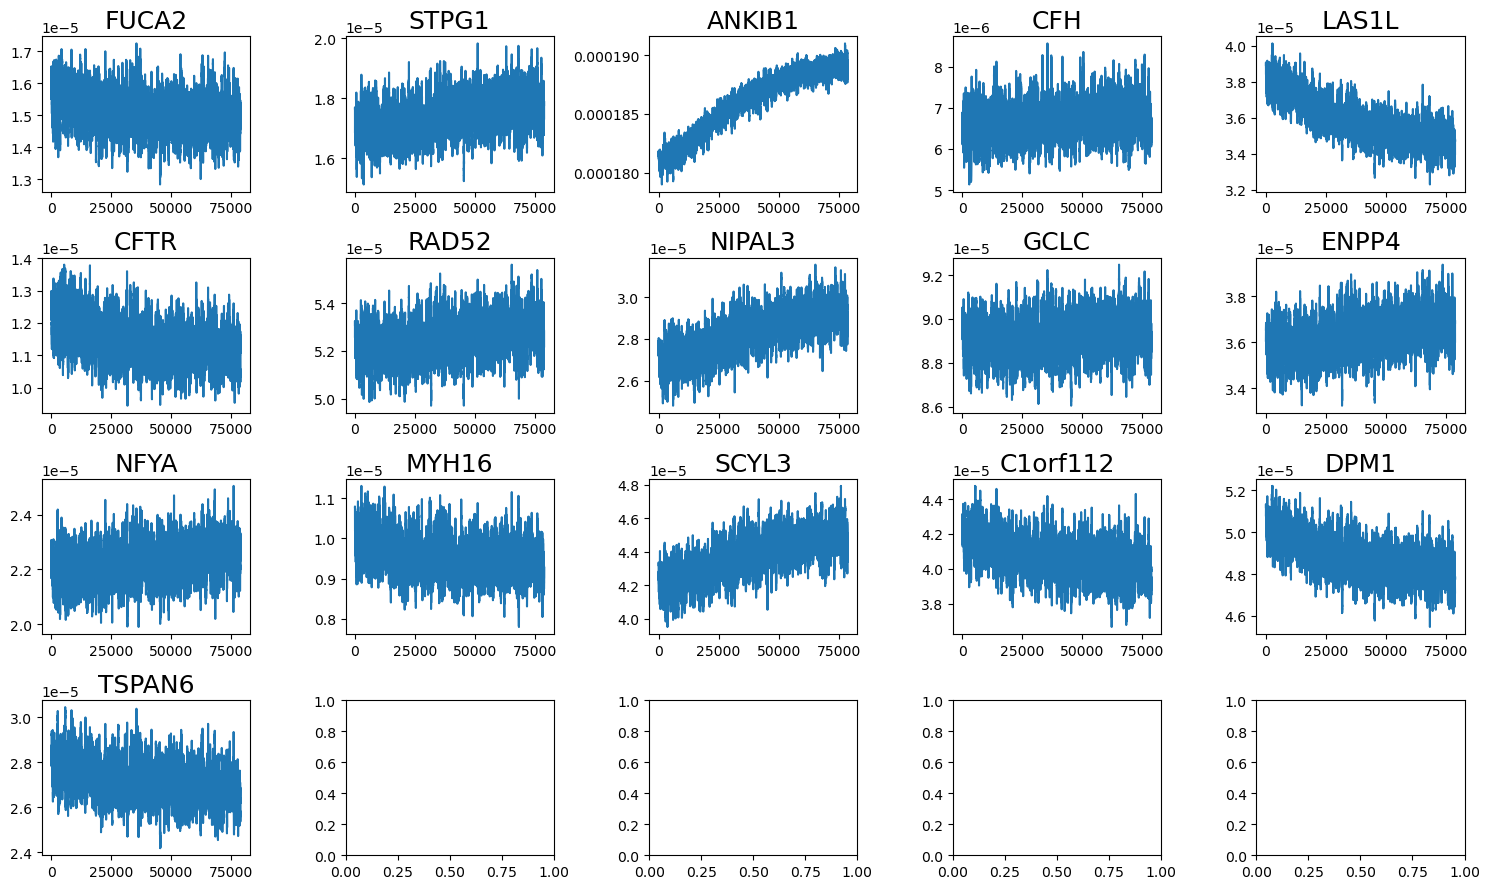

In [53]:
fig, ax = plt.subplots(4,5,figsize=(15,9))
nf = 100
f = np.ones(nf) / nf
for n, i in enumerate(idx_gene[:20]):
    axis = ax[n // 5, n % 5]
    y1 = signal.convolve(y[idx_cell, i], f)
    axis.plot(y1[nf:-nf])
    axis.set_title(f"{gene_names[i]}", fontsize=18)
    
plt.tight_layout()
plt.show()

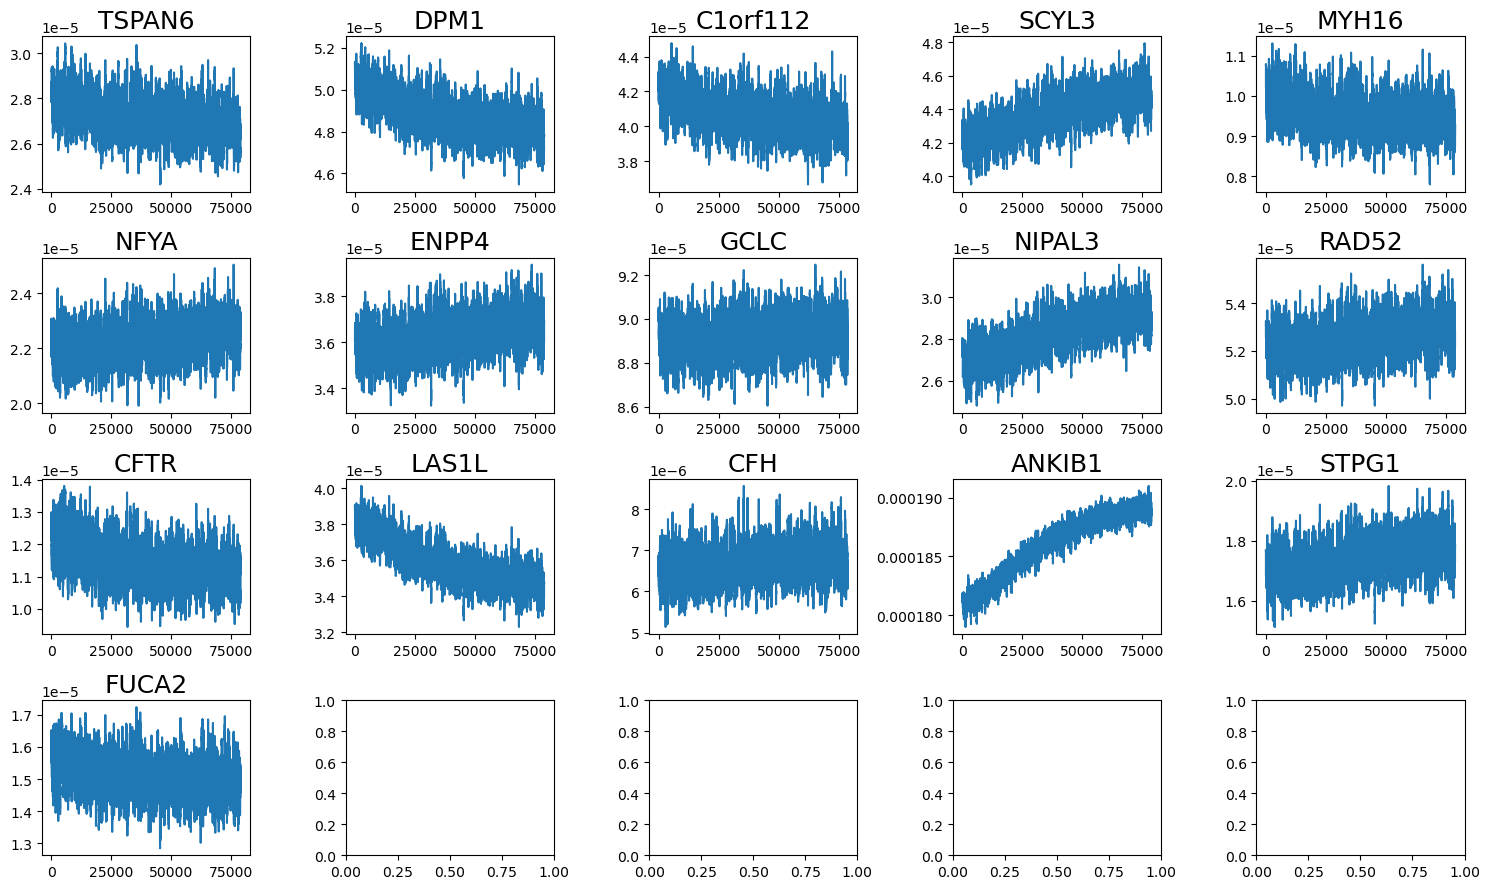

In [54]:
fig, ax = plt.subplots(4,5,figsize=(15,9))
for n, i in enumerate(idx_gene[-20:][::-1]):
    axis = ax[n // 5, n % 5]
    y1 = signal.convolve(y[idx_cell, i], f)
    axis.plot(y1[nf:-nf])
    axis.set_title(f"{gene_names[i]}", fontsize=18)
    
plt.tight_layout()
plt.show()


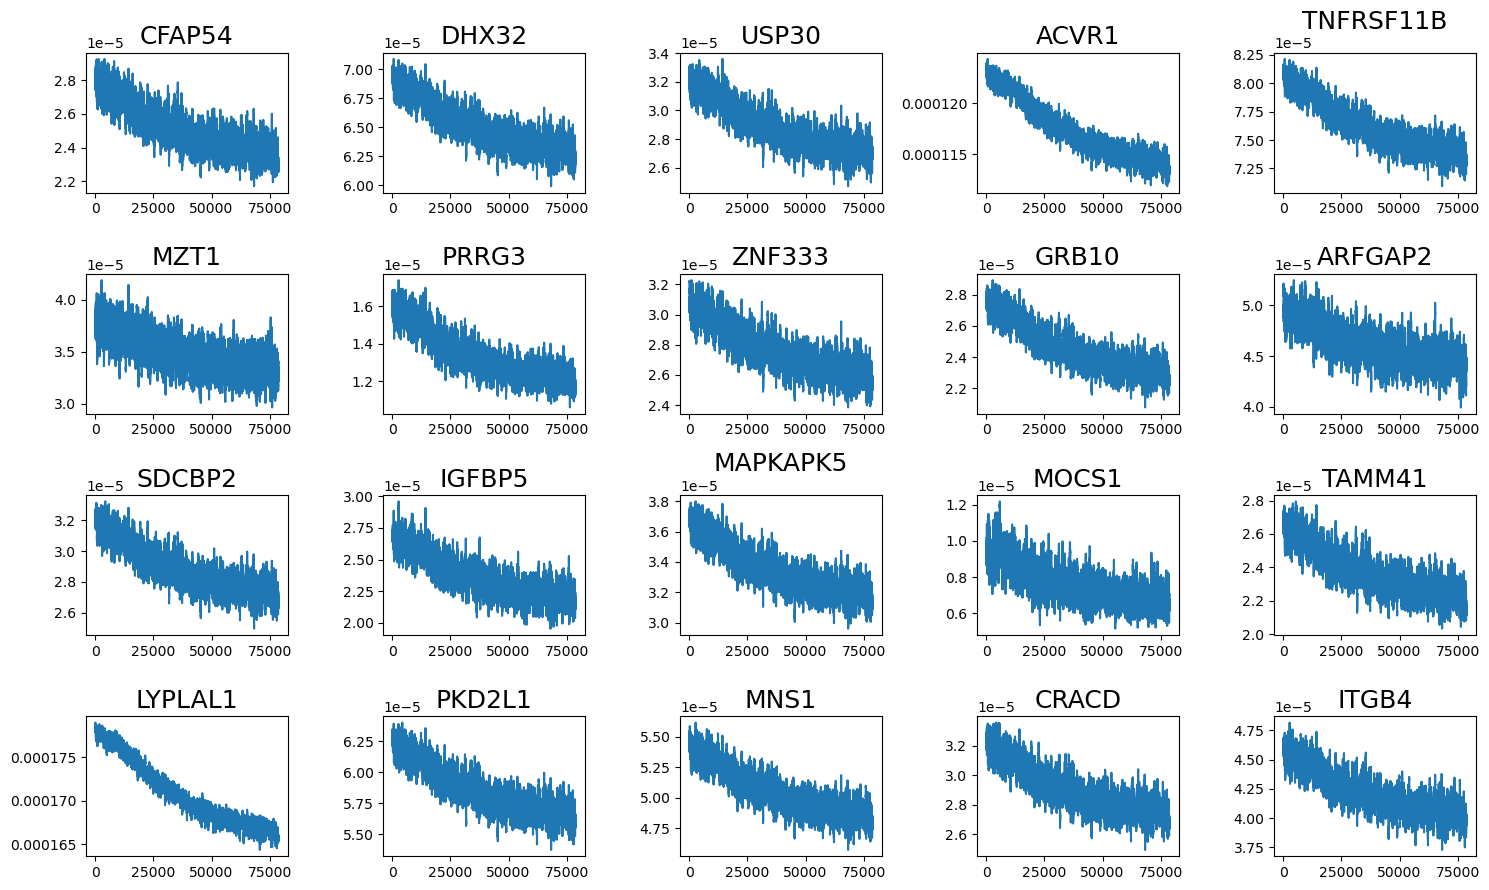

In [50]:
fig, ax = plt.subplots(4,5,figsize=(15,9))
for n, i in enumerate(idx_gene[1000:1020]):
    axis = ax[n // 5, n % 5]
    y1 = signal.convolve(y[idx_cell, i], f)
    axis.plot(y1[nf:-nf])
    axis.set_title(f"{gene_names[i]}", fontsize=18)
    
plt.tight_layout()
plt.show()


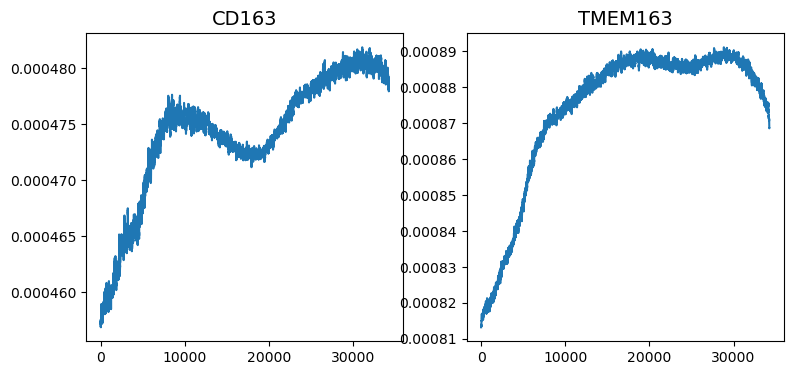

In [61]:
fig, ax = plt.subplots(5,5,figsize=(20,15))
f = np.ones(50) / 50
for n, i in enumerate(list(range(975, 1000))):
    axis = ax[n // 5, n % 5]
    y1 = signal.convolve(y[idx, i], f)
    axis.plot(y1[50:-50])
    axis.set_title(f"{gene_names[i]}  protein: {protein_coding[i]}", fontsize=15)
    
plt.tight_layout()
plt.show()

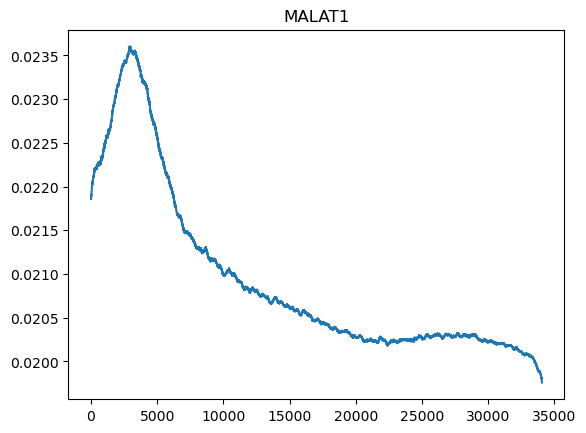

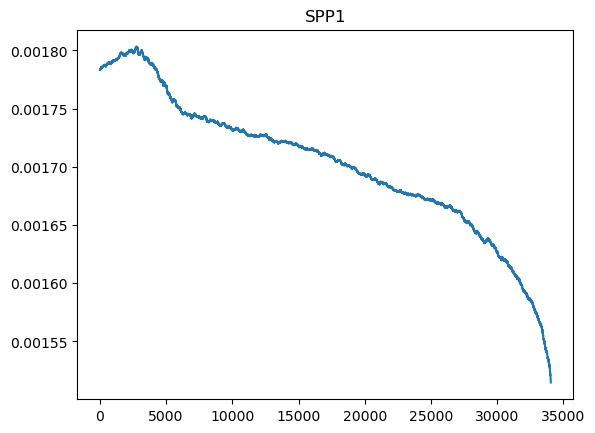

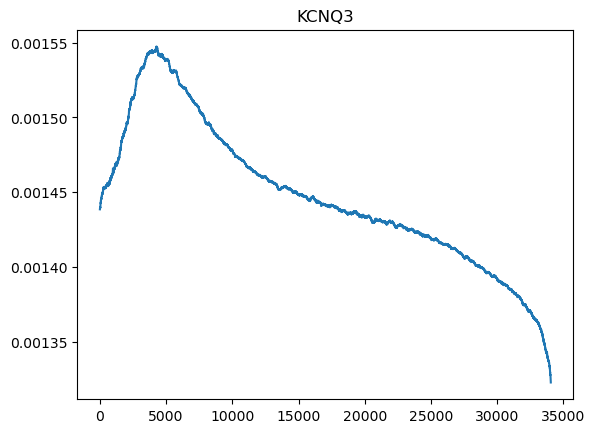

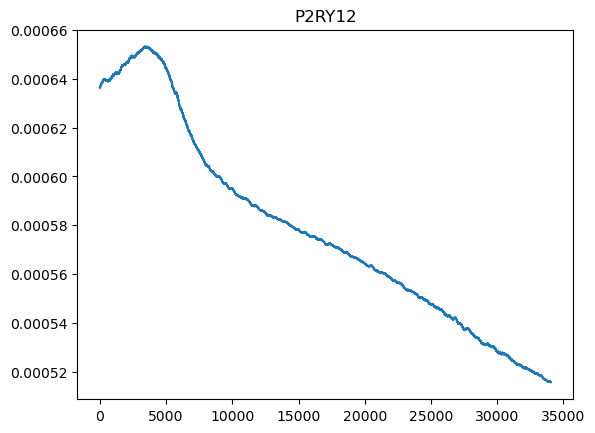

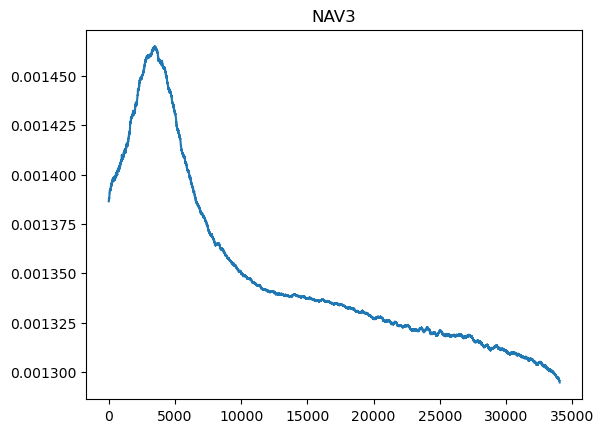

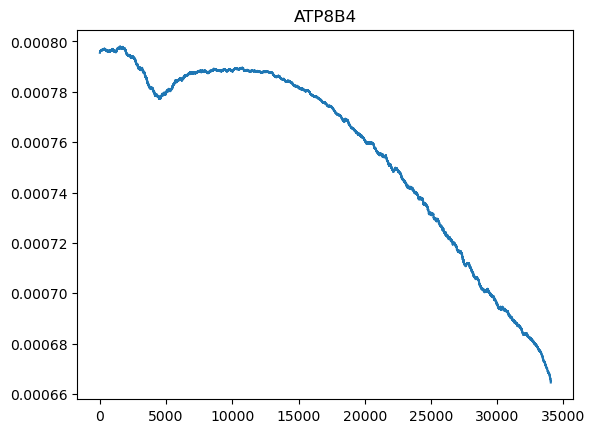

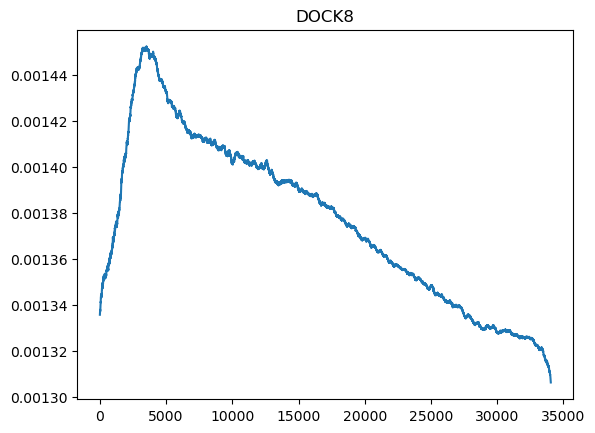

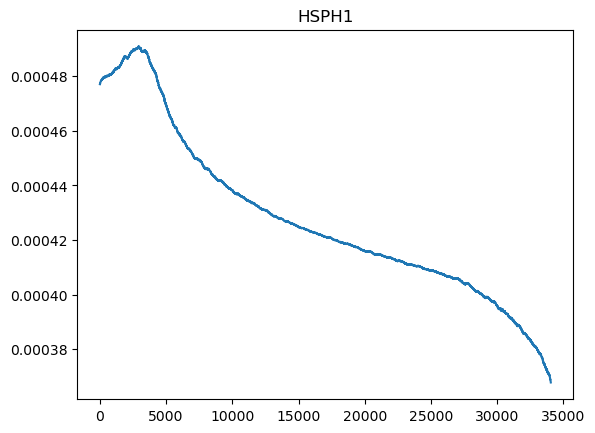

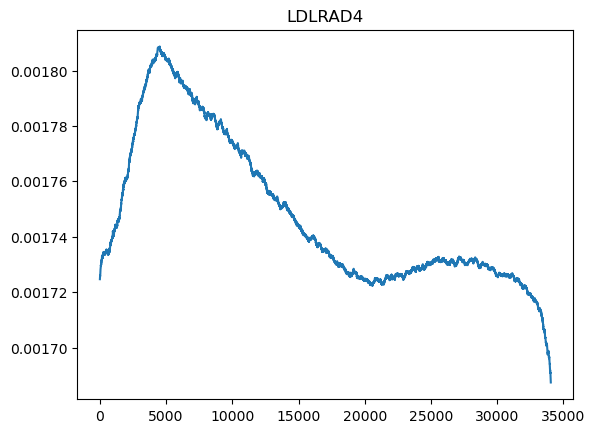

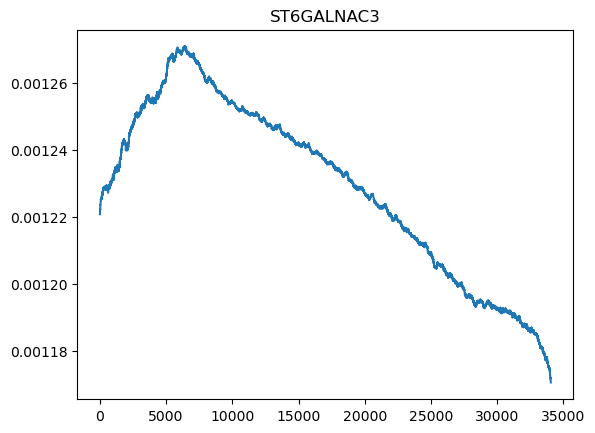

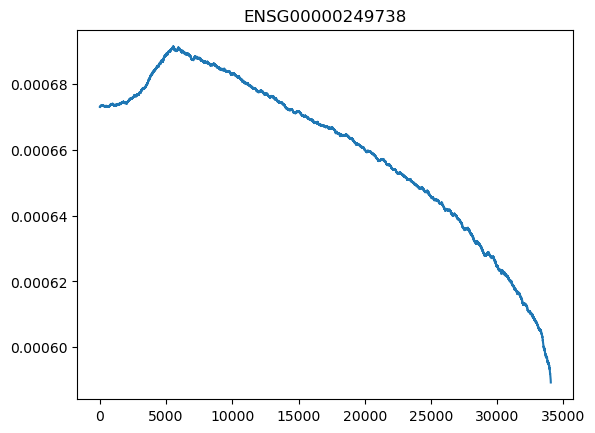

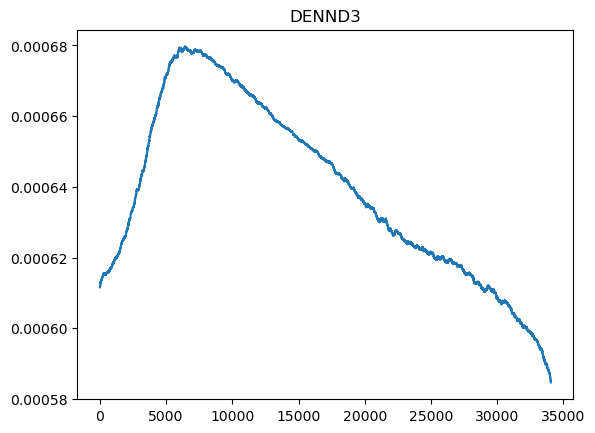

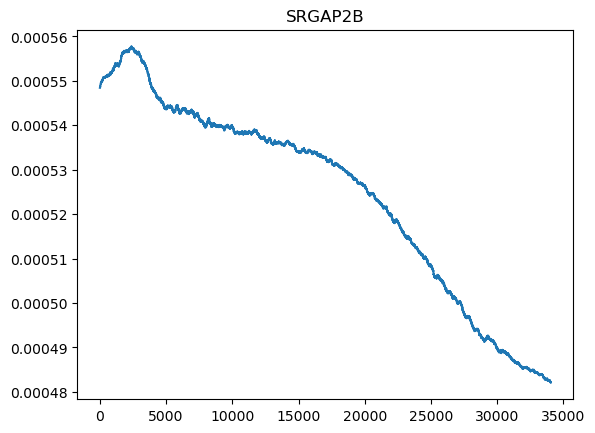

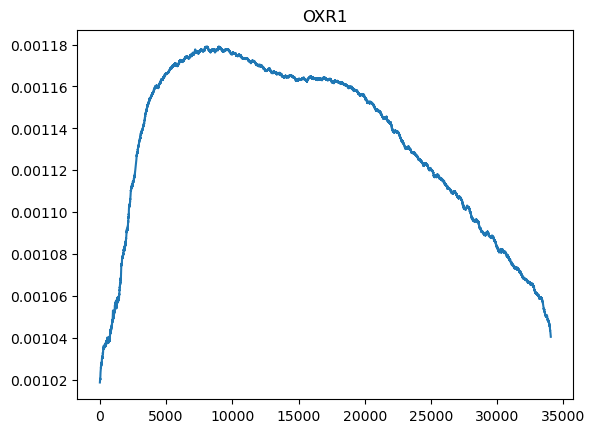

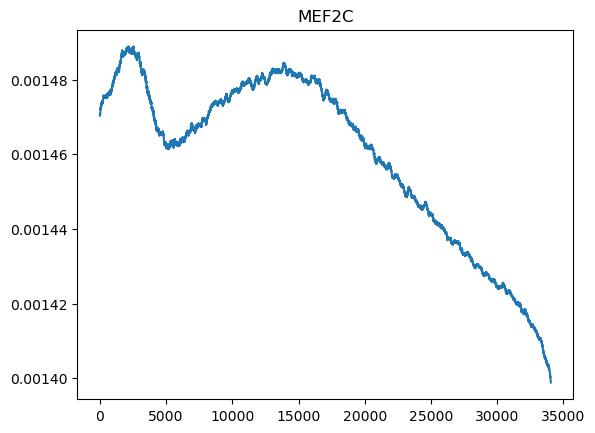

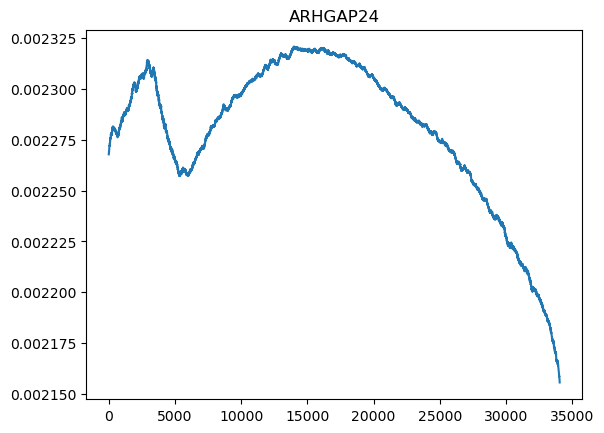

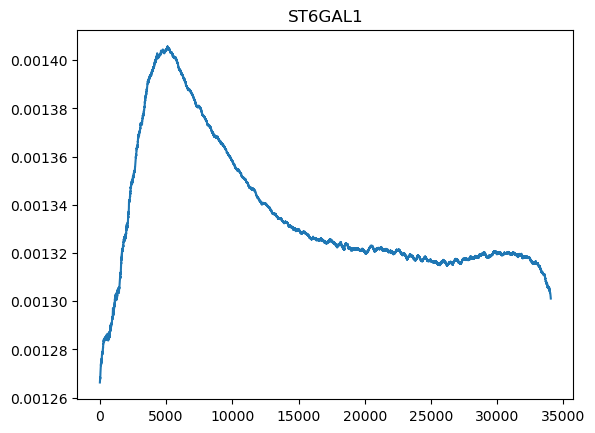

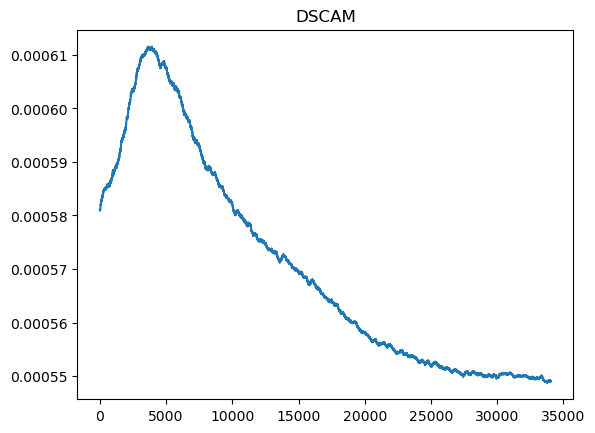

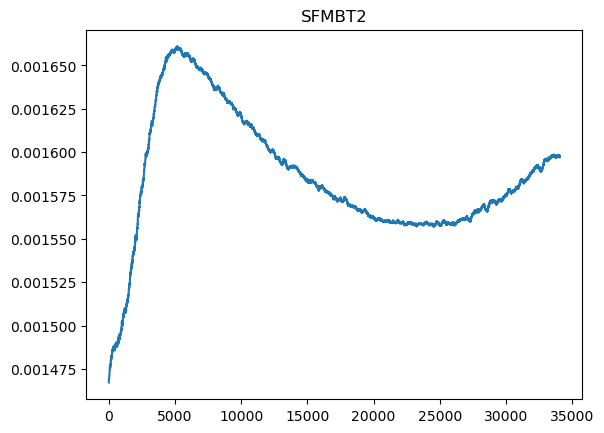

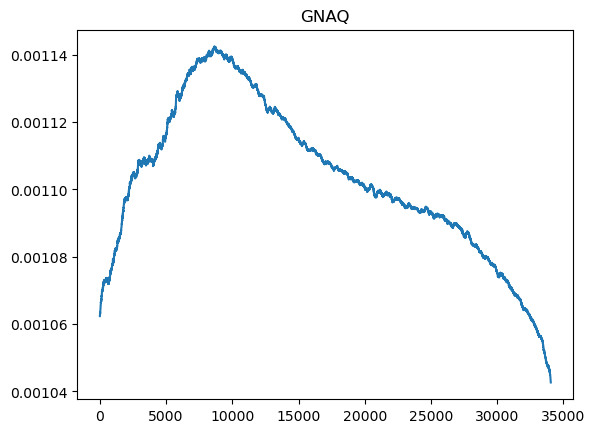

-1.2983997 -1.6509256
6372
[array([8.035281 , 7.7986007], dtype=float32)]


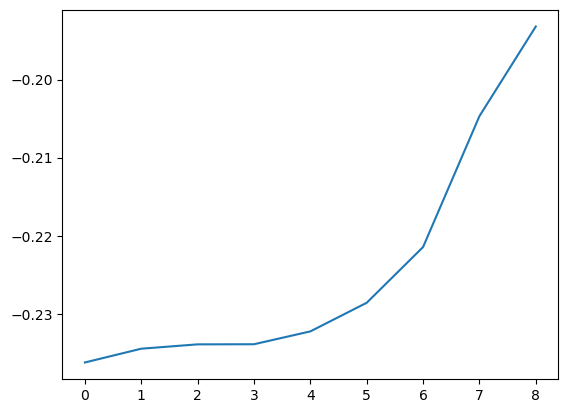

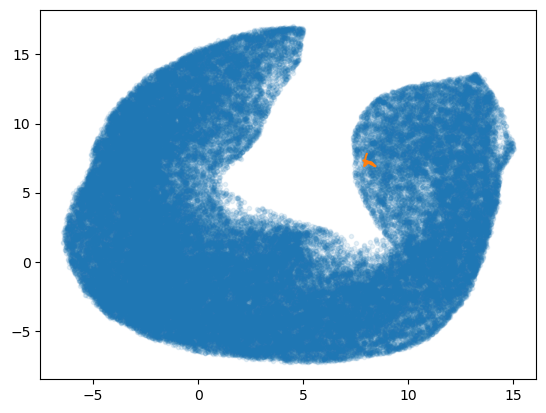

In [69]:
unique_cerad = np.unique(adata.obs['CERAD'])
unique_cerad = unique_cerad[unique_cerad != 0]
unique_braak = np.unique(adata.obs['BRAAK_AD'])
unique_braak = unique_braak[unique_braak != 0]

print(unique_cerad[0], unique_braak[0])

initial_cond = {"AD": 0, "Dementia": 0, 'CERAD': unique_cerad[0], "BRAAK_AD": unique_braak[0]}
x, scores, time = simulate_trajectory(a0, initial_cond, obs_gradient="mean_pred_CERAD")

plt.plot(scores)
plt.show()
umap = a0.obsm["X_umap"]
x = np.vstack(x)
plt.plot(umap[:, 0], umap[:, 1], '.', alpha=0.1)
plt.plot(x[:, 0], x[:, 1])
plt.show()

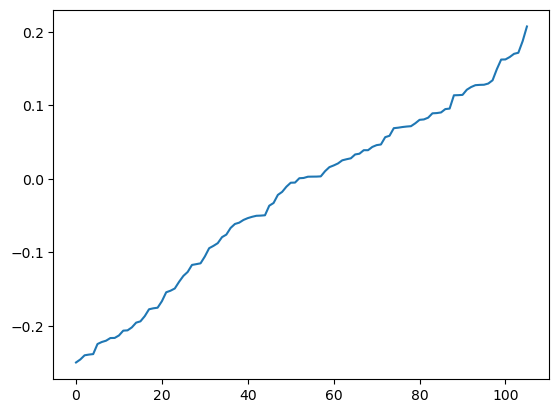

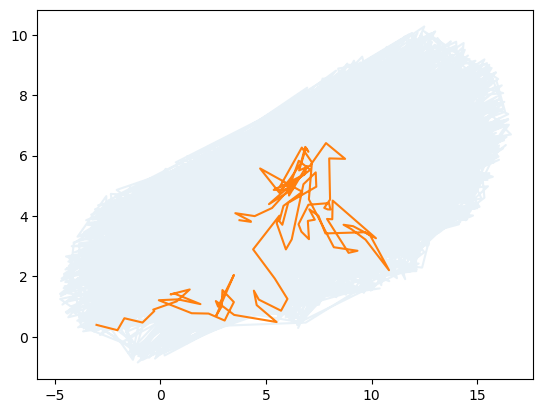

In [73]:
adata.obsm['X_pca'] = latent[:, :8]

In [74]:
a0 = adata[adata.obs["subclass"] == "Micro"]

In [75]:
a0

View of AnnData object with n_obs × n_vars = 6182 × 32
    obs: 'AD', 'Dementia', 'CERAD', 'BRAAK_AD', 'Sex', 'class', 'subclass', 'Age', 'PMI', 'ApoE_gt', 'Cognitive_Resilience', 'Cognitive_and_Tau_Resilience'
    obsm: 'X_pca'

In [76]:
sc.pp.neighbors(a0, n_neighbors=30)
sc.tl.umap(a0)

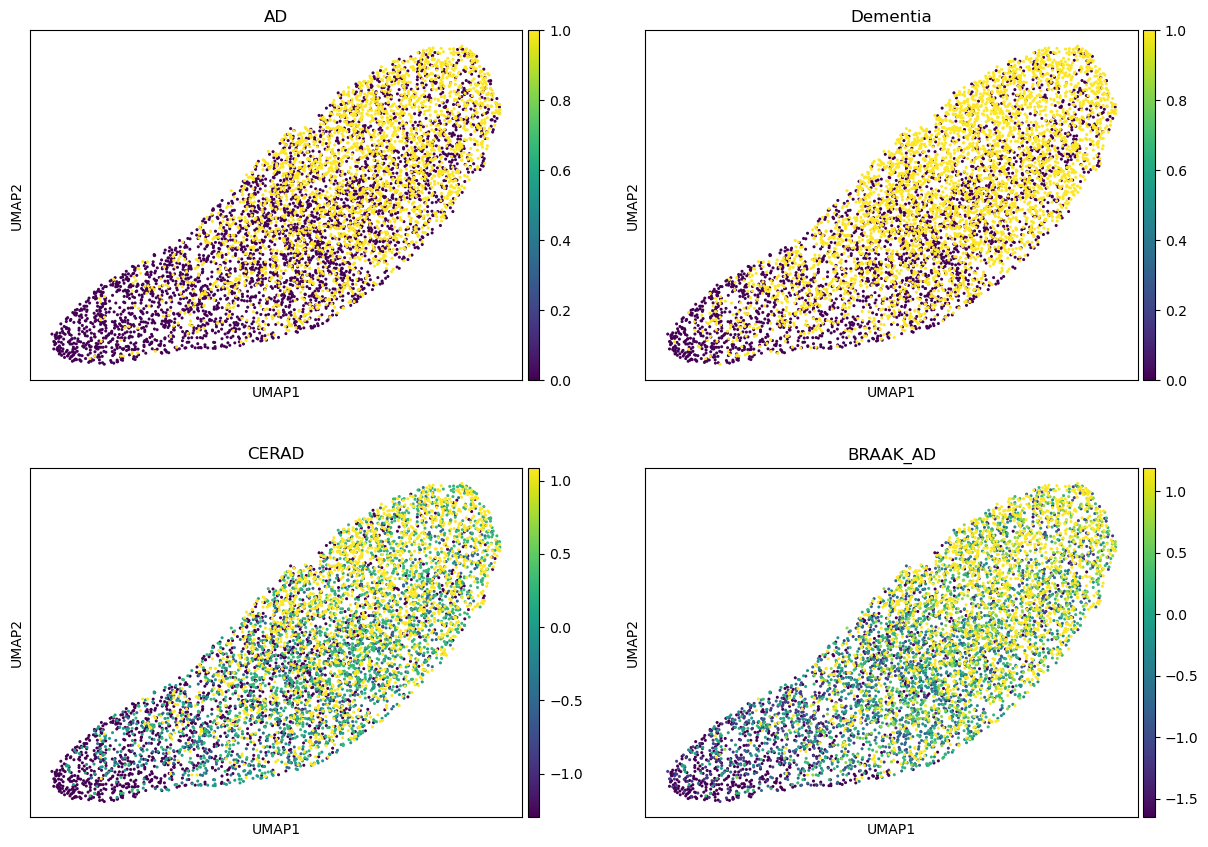

In [77]:
sc.pl.umap(a0, color=["AD", "Dementia", "CERAD", "BRAAK_AD"], ncols=2)

In [78]:
for obs in obs_list[:4]:
    x = []
    s = np.array(a0.obs[obs])
    for n in range(a0.shape[0]):
        c = np.array(a0.obsp["connectivities"][n, :].todense()).squeeze()
        count = np.sum(c > 0)
        x.append(np.sum(s * c) / count)
    a0.obs[f"mean_{obs}"] = x

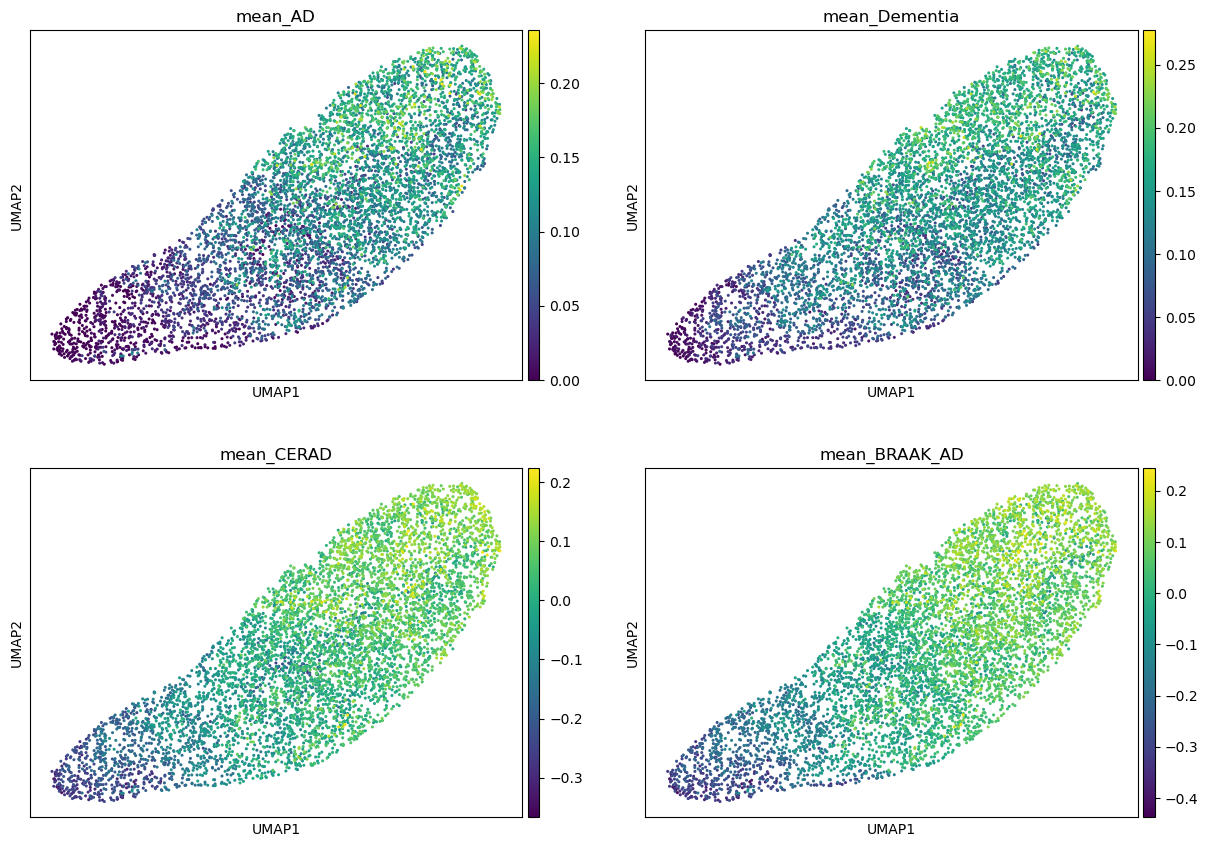

In [80]:
sc.pl.umap(a0, color=["mean_AD", "mean_Dementia", "mean_CERAD", "mean_BRAAK_AD"], ncols=2)

In [43]:
sc.pp.neighbors(a0, n_neighbors=30)

KeyError: 'connectivities'

In [192]:

path = f"/home/masse/work/vae/lightning_logs/version_{v_num}/checkpoints/"
fns = os.listdir(path)
fn = path + fns[0]

model_cfg["n_input"] = 13_585
network = VAE(**model_cfg)
network = load_model(fn, network)

n_input 13585 n_hidden 1024
network.px_r
network.z_encoder.encoder.fc_layers.0.weight
network.z_encoder.encoder.fc_layers.0.bias
network.z_encoder.encoder.fc_layers.2.weight
network.z_encoder.encoder.fc_layers.2.bias
network.z_encoder.encoder.fc_layers.4.weight
network.z_encoder.encoder.fc_layers.4.bias
network.z_encoder.encoder.fc_layers.6.weight
network.z_encoder.encoder.fc_layers.6.bias
network.z_encoder.encoder.fc_layers.8.weight
network.z_encoder.encoder.fc_layers.8.bias
network.z_encoder.mean_encoder.weight
network.z_encoder.mean_encoder.bias
network.z_encoder.var_encoder.weight
network.z_encoder.var_encoder.bias
network.l_encoder.encoder.fc_layers.0.weight
network.l_encoder.encoder.fc_layers.0.bias
network.l_encoder.mean_encoder.weight
network.l_encoder.mean_encoder.bias
network.l_encoder.var_encoder.weight
network.l_encoder.var_encoder.bias
network.decoder.px_decoder.fc_layers.0.weight
network.decoder.px_decoder.fc_layers.0.bias
network.decoder.px_decoder.fc_layers.2.weight
net

In [19]:
unique_cerad = np.unique(adata.obs["CERAD"])
unique_cerad = unique_cerad[unique_cerad != 0]
unique_cerad

array([-1.2983997 , -0.50275826,  0.2928832 ,  1.0885247 ], dtype=float32)

In [42]:
unique_cerad = np.unique(adata.obs["CERAD"])
unique_cerad = unique_cerad[unique_cerad != 0]

idx = adata.obs['AD'] == 0
m0 = np.mean(adata.X[idx, :], axis=0)
idx = adata.obs['AD'] == 1
m1 = np.mean(adata.X[idx, :], axis=0)

px = network.decoder.px_decoder(torch.from_numpy(m0[None, :]))
y0 = network.decoder.px_scale_decoder(px)

px = network.decoder.px_decoder(torch.from_numpy(m1[None, :]))
y1 = network.decoder.px_scale_decoder(px)

y0 = y0.detach().cpu().numpy()
y1 = y1.detach().cpu().numpy()

diff = y1[0, :] - y0[0, :]
idx = np.argsort(diff)[::-1]

"\nidx = adata.obs['AD'] == 0\nm0 = np.mean(adata.X[idx, :], axis=0)\nidx = adata.obs['AD'] == 1\nm1 = np.mean(adata.X[idx, :], axis=0)\n"

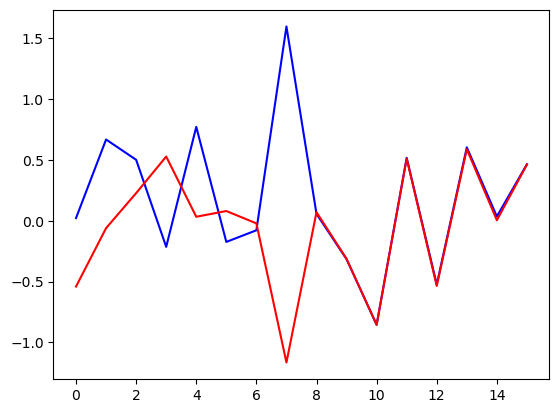

In [43]:
plt.plot(m0,'b')
plt.plot(m1, 'r')
plt.show()

In [105]:

px = network.decoder.px_decoder(torch.from_numpy(m0[None, :]))
y0 = network.decoder.px_scale_decoder(px)

px = network.decoder.px_decoder(torch.from_numpy(m1[None, :]))
y1 = network.decoder.px_scale_decoder(px)

In [106]:
y0 = y0.detach().cpu().numpy()
y1 = y1.detach().cpu().numpy()

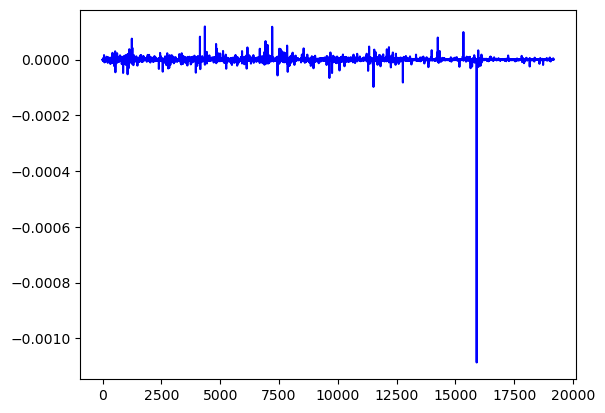

In [107]:
plt.plot(y1[0, :] - y0[0, :], 'b')
plt.show()

In [108]:
diff = y1[0, :] - y0[0, :]
idx = np.argsort(diff)[::-1]

### Top 20 upregulated genes

In [109]:
for i in idx[:20]:
    print(meta["var"]["gene_name"][i], diff[i])

ITPR2 0.0001190952
LRMDA 0.00011802092
NEAT1 9.895279e-05
PLXDC2 8.24891e-05
LINC00486 7.931073e-05
SLC1A3 7.541012e-05
ARHGAP26 6.656232e-05
DOCK4 5.632732e-05
SDK1 5.280017e-05
ELMO1 5.0472445e-05
HS3ST4 4.702364e-05
FHIT 4.485878e-05
ETV6 4.382251e-05
EPB41L2 4.2360625e-05
DISC1 4.0468178e-05
CEP170 3.9226317e-05
GRID2 3.921194e-05
ARHGAP22 3.9165898e-05
MBNL1 3.856118e-05
ARHGAP15 3.7508085e-05


### Top 20 downregulated genes

In [110]:
for i in idx[-20:]:
    print(meta["var"]["gene_name"][i], diff[i])

DOCK8 -3.1609787e-05
BMP2K -3.216637e-05
VPS13B -3.252647e-05
ATP8B4 -3.3262884e-05
HSPH1 -3.4083117e-05
DSCAM -3.8741447e-05
UBE2E2 -4.008424e-05
DENND3 -4.3069653e-05
ST6GALNAC3 -4.37072e-05
GNAQ -4.370988e-05
CELF2 -4.521117e-05
SPP1 -4.6664965e-05
NAV3 -4.7692563e-05
P2RY12 -4.7948444e-05
ST6GAL1 -5.234941e-05
FRMD4A -5.6551304e-05
LDLRAD4 -6.572786e-05
SFMBT2 -8.199422e-05
KCNQ3 -9.77742e-05
MALAT1 -0.0010868777


In [40]:
idx = np.where(meta["var"]["gene_name"] == "PICALM")[0]
diff[idx[0]]

4.2095315e-05

In [41]:
idx = np.where(meta["var"]["gene_name"] == "CD163")[0]
diff[idx[0]]

5.4743723e-06

In [40]:
meta["obs"].keys()

dict_keys(['CERAD', 'BRAAK_AD', 'BRAAK_PD', 'Dementia', 'AD', 'class', 'subclass', 'subtype', 'ApoE_gt', 'Sex', 'Head_Injury', 'Vascular', 'Age', 'Epilepsy', 'Seizures', 'Tumor', 'PD', 'ALS', 'CDRScore', 'PMI', 'Cognitive_Resilience', 'Cognitive_and_Tau_Resilience', 'SubID', 'snRNAseq_ID', 'SCZ', 'MDD', 'Brain_bank', 'prep', 'rep'])

In [90]:
print(np.mean(meta["obs"]["SCZ"] > 0))
print(np.mean(meta["obs"]["CERAD"] < 0))
print(np.mean((meta["obs"]["SCZ"] > 0) * (meta["obs"]["CERAD"] < 0)))

0.1174728148657949
0.10337370956641431
0.018816242257398485


In [47]:
print(np.mean(meta["obs"]["MDD"] > 0))
print(np.mean(meta["obs"]["CERAD"] > 1))
print(np.mean((meta["obs"]["MDD"] > 0) * (meta["obs"]["CERAD"] > 1)))

0.006218857536132141
0.628294562973159
0.006218857536132141


In [89]:
print(np.mean(meta["obs"]["ALS"] > 0))
print(np.mean(meta["obs"]["CERAD"] < 0))
print(np.mean((meta["obs"]["ALS"] > 0) * (meta["obs"]["CERAD"] < 0)))
#idx = np.where((meta["obs"]["ALS"] > 0))[0]
#meta["obs"]["CERAD"][idx]


0.005167240192704749
0.10337370956641431
0.005167240192704749


In [49]:
print(np.mean(meta["obs"]["PD"] > 0))
print(np.mean(meta["obs"]["CERAD"] > 1))
print(np.mean((meta["obs"]["PD"] > 0) * (meta["obs"]["CERAD"] > 1)))

0.03479146593255334
0.628294562973159
0.023863730213351687


In [54]:
print(np.mean(meta["obs"]["Seizures"] > 0))
print(np.mean(meta["obs"]["CERAD"] > 1))
print(np.mean((meta["obs"]["Seizures"] > 0) * (meta["obs"]["CERAD"] > 1)))

0.0
0.628294562973159
0.0


In [45]:
idx = meta["obs"]["Sex"] == "Male"
u, c = np.unique(meta["obs"]["CERAD"][idx], return_counts=True)
print(c /np.sum(c))
idx = meta["obs"]["Sex"] == "Female"
u, c = np.unique(meta["obs"]["CERAD"][idx], return_counts=True)
print(c / np.sum(c))

[0.10977293 0.34594187 0.07240437 0.2505127  0.22136813]
[0.09783884 0.20120444 0.17763163 0.22130409 0.302021  ]


In [ ]:
p